# Graph of words and keywords extraction

This notebook is dedicated to people who want to **extract keywords** from text document or corpus documents using a **graph approach**.

The goal of this notebook is to extract keywords from a text file using three different approachs :
- Best Coverage keywords extraction - http://www2013.w3c.br/proceedings/p715.pdf
- Div Rank keywords extraction - http://clair.si.umich.edu/~radev/papers/SIGKDD2010.pdf
- K-core Number 
----

The parameters that can be modify are about :
- The type and choice of libraries for tokennization (NLTK, Spacy, StanfordNLP), the stopword list, the effectiveness of the steaming
- The type of graph (directed or not, weighted or not)
- The type of data (a graph for a text or for a corpus)

You need more explanations about the the textacy library ? https://media.readthedocs.org/pdf/textacy/latest/textacy.pdf

----
## Introduction
---

Here are the following steps : 
- Preprocess the text (nltk, spacy) - clean_text_simple_by_sents
- Create the input for the K-core algorithm - terms_to_graph_sents 
- Develop the K-core algorithm (networkx)
- Plot the entire graph and the best subgraph 
- Compare the keywords extraction methods 

Variables : 
- The path of your text file has to be set in "filename" (a list of strings)
- The number of keywords to extract have to be indicate in "nb_keys_terms_needed" 
- Many other parameters can be modified in the notebook

In [50]:
filename='/Users/newuser/Documents/LILI/EvoHDP_code/Test_GOT/txt_GOT/GoTS06E07_L_Homme_brisé.txt'
nb_keys_terms_needed=50

In [51]:
import networkx as nx
import re 
import itertools
import operator
import copy
import heapq
import nltk
from nltk.corpus import stopwords
# requires nltk 3.2.1
from nltk import pos_tag
import string
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from networkx import k_core
from networkx import core_number
import spacy
import sys
import numpy as np
import textacy
from nltk.tokenize import word_tokenize,wordpunct_tokenize
import networkx.drawing
import textacy.keyterms
import pandas as pd
nlp = spacy.load('fr')

In [52]:
stop_words=['à','soudain','presque', 'ensuite','l','bold_color','color_','italic_color_''d','s','de','un', 'une','alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des','du','dedans','dehors'
    ,'depuis','devrait','doit','donc','dos','début','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il','ils','je','juste'
    ,'la','le','les','leur','là','ma','maintenant','mais','mes','mine','moins','mon','mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement'
    ,'si','sien','son','sont','sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton','tous','tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être',"a","abord","absolument","afin","ah","ai","aie","aient","aies"
    ,"ailleurs","ainsi","ait","allaient","allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez","attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai","auraient","aurais","aurait","auras"
    ,"aurez","auriez","aurions","aurons","auront","aussi","autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah","bas","basee","bat"
    ,"beau","beaucoup","bien","bon","boum","bravo","brrr","c","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet"
    ,"cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche","chut","chère","chères","ci","cinq","cinquantaine","cinquantième","cinquième","clac","clic","combien","comme","comment","comparable","comparables","compris","concernant"
    ,"contre","couic","crac","d","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere","derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","devrait","different"
    ,"differentes","differents","différent","différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers","diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont","dos","douze","douzième","dring","droite"
    ,"du","duquel","durant","dès","début","désormais","e","effet","egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse"
    ,"eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez"
    ,"fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","huit","huitième","hum","hurrah","hé","hélas"
    ,"i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi"
    ,"moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre"
    ,"ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement"
    ,"pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire"
    ,"pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu"
    ,"quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième"
    ,"quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi"
    ,"sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous"
    ,"souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant"
    ,"toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan"
    ,"voici","voie","voient","voilà","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","«",""
    ,"w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]

------
## Preprocess the text (nltk, spacy)
------

In [54]:
doc=open(filename,'r')
text=doc.read()
doc.close()
print(text[:900])

À Port-Réal, Margaery s’entretient avec le Grand Moineau et semble totalement sous l’emprise de la Foi. Celui-ci la met en garde sur l’influence néfaste de sa grand-mère qui doit selon lui se repentir de ses péchés. Revenue au Donjon Rouge, la jeune reine, accompagnée de Septa Unella, confronte Olenna en lui demandant froidement de retourner à Hautjardin, tout en lui donnant discrètement un message du coin de sa robe. Olenna accepte de partir puis, dans le couloir, sourit en voyant une rose, le symbole de la Maison Tyrell, dessinée sur le parchemin : Margaery mène en réalité un double jeu contre le Grand Moineau. Olenna est ensuite confrontée à Cersei qui désire prolonger leur trêve afin de sauver Tommen. Olenna lui conseille de partir comme elle, vu que la Reine-Mère n’a plus aucun allié dans la capitale, et ne peut s’empêcher de lui dire que le malheur de Cersei, seule responsable de l


In [80]:
def txt_to_sentences(file_title):
    with open(file_title, "r") as text:
        # Preprocessing from text
        text = str(text.read())
        text=text.lower()
        text=textacy.preprocess.normalize_whitespace(text)
        text=textacy.preprocess.fix_bad_unicode(text, normalization=u'NFKC')
        text=textacy.preprocess.preprocess_text(text, fix_unicode=False, lowercase=False, transliterate=False, no_urls=False,no_phone_numbers=False,no_currency_symbols=False,
        no_emails=True, no_numbers=False, no_punct=False,no_contractions=False, no_accents=False)
        text=textacy.preprocess.unpack_contractions(text)
        nlp_text=textacy.Doc(text).pos_tagged_text
        # Sentence and word separation with SPACY
        #nlp_text=nlp(text).pos_tagged_text
        #print(len(nlp_text))
        #sentences_Spacy = list(wordpunct_tokenize(text))
        # with only lowercase, it works better
        #sents = [" ".join([w.text for w in sent]) for sent in nlp_text.sents]
        #return sents 
        #return sentences_Spacy
        return(nlp_text)
txt_sentences=txt_to_sentences(filename)
txt_sentences[:1]

[[('à', 'ADP'),
  ('port-réal', 'NOUN'),
  (',', 'PUNCT'),
  ('margaery', 'NOUN'),
  ("s'", 'PRON'),
  ('entretient', 'VERB'),
  ('avec', 'ADP'),
  ('le', 'DET'),
  ('grand', 'ADJ'),
  ('moineau', 'NOUN'),
  ('et', 'CCONJ'),
  ('semble', 'VERB'),
  ('totalement', 'ADV'),
  ('sous', 'ADP'),
  ("l'", 'DET'),
  ('emprise', 'NOUN'),
  ('de', 'ADP'),
  ('la', 'DET'),
  ('foi', 'NOUN'),
  ('.', 'PUNCT')]]

In [81]:
def clean_text_simple_by_sents(tok_sent_tagged, my_stopwords, remove_stopwords=True, pos_filtering=True, stemming=True):
    cleaned_text=[]
    for i,phrase in enumerate(tok_sent_tagged):
        tokens=[]
        for words in enumerate(phrase):
            #tokens = text.split(' ')
            if pos_filtering == True:
                # POS tag and retain only nouns and adjectives
                if (words[1][1] == 'NOUN' or words[1][1] == 'ADJ'):
                    tokens.append(words[1][0])
            else:
                tokens.append(words[1][0])   
        #print(tokens)
        if remove_stopwords:
            # remove stopwords
            tokens = [token for token in tokens if token not in my_stopwords]
        if stemming:
            # apply Porter's stemmer
            stemmer = nltk.stem.PorterStemmer()
            tokens_stemmed = list()
            for token in tokens:
                tokens_stemmed.append(stemmer.stem(token))
            tokens = tokens_stemmed
        cleaned_text.append(tokens)

    return(cleaned_text)
clean_txt_sents=clean_text_simple_by_sents(txt_sentences, stop_words,remove_stopwords=True, pos_filtering=True, stemming=False)
clean_txt_sents[1:5]

[['met', 'garde', 'influence', 'néfaste', 'grand-mère', 'péchés'],
 ['donjon',
  'rouge',
  'jeune',
  'reine',
  'septa',
  'unella',
  'confronte',
  'hautjardin',
  'message',
  'coin',
  'robe'],
 ['couloir',
  'rose',
  'symbole',
  'maison',
  'tyrell',
  'parchemin',
  'margaery',
  'réalité',
  'double',
  'jeu',
  'grand',
  'moineau'],
 ['cersei', 'trêve', 'tommen']]

------
## Create the input for the K-core algorithm
------

In [83]:
def terms_to_graph_sents(clean_txt_sents, w):
    from_to = {}
    for k,sents in enumerate(clean_txt_sents):
        len_sents=len(sents)

        # create initial complete graph (first w terms)
        terms_temp = sents[0:min(w,len_sents)]
        indexes = list(itertools.combinations(range(min(w,len_sents)), r=2))
        new_edges = []
        for my_tuple in indexes:
            new_edges.append(tuple([terms_temp[i] for i in my_tuple]))

        for new_edge in new_edges:
            if new_edge in from_to:
                from_to[new_edge] += 1
            else:
                from_to[new_edge] = 1

        if(w<=len_sents):
            # then iterate over the remaining terms
            for i in range(w, len_sents):
                considered_term = sents[i] # term to consider
                terms_temp = sents[(i-w+1):(i+1)] # all terms within sliding window

                # edges to try
                candidate_edges = []
                for p in range(w-1):
                    candidate_edges.append((terms_temp[p],considered_term))

                for try_edge in candidate_edges:

                    if try_edge[1] != try_edge[0]:
                    # if not self-edge

                        # if edge has already been seen, update its weight
                        if try_edge in from_to:
                            from_to[try_edge] += 1

                        # if edge has never been seen, create it and assign it a unit weight     
                        else:
                            from_to[try_edge] = 1
    
    return(list(from_to.keys()))

tuples_words_sents=terms_to_graph_sents(clean_txt_sents, w=5)
tuples_words_sents[:30]

[('port-réal', 'margaery'),
 ('port-réal', 'grand'),
 ('port-réal', 'moineau'),
 ('port-réal', 'emprise'),
 ('margaery', 'grand'),
 ('margaery', 'moineau'),
 ('margaery', 'emprise'),
 ('grand', 'moineau'),
 ('grand', 'emprise'),
 ('moineau', 'emprise'),
 ('margaery', 'foi'),
 ('grand', 'foi'),
 ('moineau', 'foi'),
 ('emprise', 'foi'),
 ('met', 'garde'),
 ('met', 'influence'),
 ('met', 'néfaste'),
 ('met', 'grand-mère'),
 ('garde', 'influence'),
 ('garde', 'néfaste'),
 ('garde', 'grand-mère'),
 ('influence', 'néfaste'),
 ('influence', 'grand-mère'),
 ('néfaste', 'grand-mère'),
 ('garde', 'péchés'),
 ('influence', 'péchés'),
 ('néfaste', 'péchés'),
 ('grand-mère', 'péchés'),
 ('donjon', 'rouge'),
 ('donjon', 'jeune')]

------
## Develop the K-core algorithm (networkx)
------

In [61]:
G = nx.Graph()
G.add_edges_from(tuples_words_sents)

In [85]:
list(G.nodes)[:10]

['port-réal',
 'margaery',
 'grand',
 'moineau',
 'emprise',
 'foi',
 'met',
 'garde',
 'influence',
 'néfaste']

In [84]:
list(G.edges)[:10]

[('port-réal', 'margaery'),
 ('port-réal', 'grand'),
 ('port-réal', 'moineau'),
 ('port-réal', 'emprise'),
 ('margaery', 'grand'),
 ('margaery', 'moineau'),
 ('margaery', 'emprise'),
 ('margaery', 'foi'),
 ('margaery', 'symbole'),
 ('margaery', 'maison')]

------
## Plot the entire graph and the best subgraph 
------

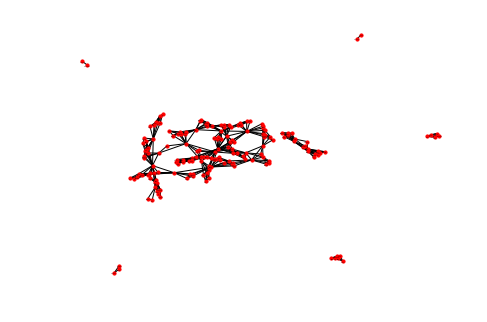

In [66]:
nx.draw(G, with_labels=True,font_size=0.02,width=1,node_size=10,label='Graph Unweighted GOT')
plt.show()
plt.savefig("kcore.png")

----
### 5-core subgraph
----

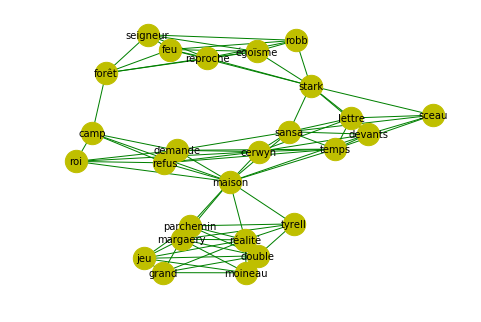

In [67]:
subgraph_k_core=k_core(G, k=5 ,core_number=None)
nx.draw(subgraph_k_core, with_labels=True,node_color='y',edge_color='g',font_size=10,width=1,node_size=500,label='Graph Unweighted GOT')
plt.show()
plt.savefig("subrgraph_kcore.png")

------
## Compare the keywords extraction methods 
------

### K-core number

In [68]:
G_core_number=core_number(G)

In [77]:
k_core_keyTerms=sorted(G_core_number, key=G_core_number.get, reverse=True)
Kcore_values=[G_core_number[x] for x in k_core_keyTerms[:nb_keys_terms_needed]]

---
### Textacy keyword extractions - DivRank
---

In [76]:
DivRank=textacy.keyterms.rank_nodes_by_divrank(G, r=None, lambda_=0.5, alpha=0.5)
sorted_DRank=sorted(DivRank, key=DivRank.get, reverse=True)
DR_values=[DivRank[x] for x in sorted_DRank[:nb_keys_terms_needed]]

-----
### Textacy keyword extractions - BestCoverage
----

In [75]:
BCoverage=textacy.keyterms.rank_nodes_by_bestcoverage(G, k=nb_keys_terms_needed, c=1, alpha=1.0)
sorted_BCov=sorted(BCoverage, key=BCoverage.get, reverse=True)
BC_values=[BCoverage[x] for x in sorted_BCov[:nb_keys_terms_needed]]

### Results

In [72]:
df_results=pd.DataFrame(columns=['Best_K_Core','Kcore_values','Div_Rank_KeyTerms','DR_values','Best_Coverage_KeyTerms','BC_values'])
df_results['Best_K_Core']=k_core_keyTerms[:50]
df_results['Div_Rank_KeyTerms']=sorted_DRank[:50]
df_results['Best_Coverage_KeyTerms']=sorted_BCov[:50]
df_results['Kcore_values']=Kcore_values
df_results['DR_values']=DR_values
df_results['BC_values']=BC_values
df_results

,Best_K_Core,Kcore_values,Div_Rank_KeyTerms,DR_values,Best_Coverage_KeyTerms,BC_values
0,margaery,5,reine,0.033785,reine,0.015734
1,grand,5,maison,0.029666,maison,0.014920
2,moineau,5,stark,0.024459,stark,0.013229
3,maison,5,jaime,0.017023,temps,0.011429
4,tyrell,5,groupe,0.015827,jaime,0.011234
5,parchemin,5,arya,0.014761,rallier,0.011193
6,réalité,5,mort,0.011787,arya,0.010892
7,double,5,bois,0.011474,groupe,0.010788
8,jeu,5,flotte,0.011205,sansa,0.010751
9,temps,5,cersei,0.010708,flotte,0.010694


# Conclusion

- Textacy provides nice implementation of keywords extractions.
- From a graph any more keywords extraction exist 

For further studies:
- Have a look a the following code and paper : https://github.com/Tixierae/EMNLP_2016
- Optimize the DivRank and BestCoverage parameters